In [4]:
# Dependencias

import json
import torch
import torch.utils.data as data
from data import Custom
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import os
from PIL import Image
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
from torchmetrics.image import StructuralSimilarityIndexMeasure

In [5]:
# Load settings

with open('./384_shortcut1_inject1_none_hq/setting.txt', 'r') as f:
    gan_args = json.load(f)

In [6]:
# Load dataloader ATTGAN repo

test_dataset = Custom('./data/custom', './data/list_attr_custom.txt', gan_args.get('img_size'), gan_args.get('attrs'))
test_dataloader = data.DataLoader(
    test_dataset, batch_size=1, num_workers=gan_args.get('num_workers'),
    shuffle=False, drop_last=False
)
# Normalizes data using mean 0.5 and std 0.5 -> range [-1, 1]

# Test Data
imgs = []
atts = []
for idx, (img_a, att_a) in enumerate(test_dataloader):
  imgs.append(img_a), 
  atts.append(att_a)
  
# Receives PIL Image (384, 384, 3) x (0, 255)
# To Tensor scales to (0, 1)
# Normalize scales to (-1, 1) [(0 - 0.5)/0.5, (1 - 0.5)/0.5]
# Outputs tensor (1, 3, 384, 384) x (-1, 1)

In [7]:
# Helper functions

# Helper functions (from COUNTGEN repo, adapted by me) 

def normalize_0_1(_img, fake = False):
  if fake:
    img = (_img - torch.min(_img))/(torch.max(_img) - torch.min(_img))
  else:
    img = (_img + 1)/(2)
  return img

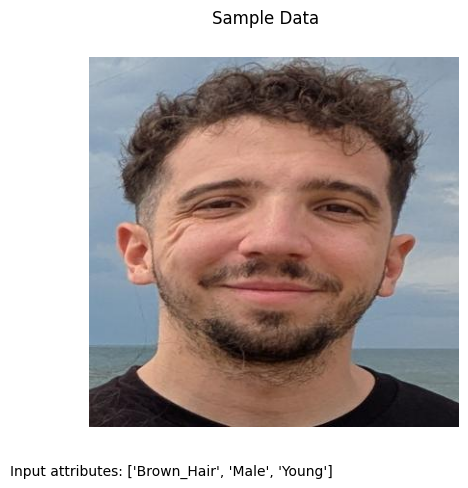

In [8]:
# Print sample data

%matplotlib inline
sample_idx = 2
img = normalize_0_1(imgs[sample_idx]).squeeze(0).permute(1, 2, 0).numpy()
att_list = [att for att, flag in zip(gan_args.get('attrs'), atts[sample_idx].tolist()[0]) if flag == 1]
plt.imshow(img)
plt.axis('off')
plt.suptitle('Sample Data')
plt.figtext(0.10, 0.01, f"""Input attributes: {att_list}""")
plt.show()

In [9]:
# Load sample training data

class CelebA_HQ(data.Dataset):
    def __init__(self, data_path, image_size, mode):
        super(CelebA_HQ, self).__init__()
        self.data_path = data_path
        
        images = ['{:d}.jpg'.format(i) for i in range(30000)]
        
        if mode == 'train':
            self.images = images[:28000]
        if mode == 'valid':
            self.images = images[28000:28500]
        if mode == 'test':
            self.images = images[28500:]
        
        self.tf = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
                                       
        self.length = len(self.images)
    def __getitem__(self, index):
        img = self.tf(Image.open(os.path.join(self.data_path, self.images[index])))
        img = normalize_0_1(img)
        return img
    def __len__(self):
        return self.length

In [10]:
# Load N samples

N = 100
image_size = 128 # downsample images for the comparison

celeba_path = '/Users/arielmalowany/Desktop/Learning/COUNT-GEN/COUNT-GEN-REPLICABILITY/celeba_hq_dataset/CelebA-HQ-img'

sample_celeba_data = CelebA_HQ(
                       data_path = celeba_path,
                       image_size = 128,
                       mode = 'train'
                     )

sample_celeba_dataloader = data.DataLoader(
                             sample_celeba_data, batch_size=N, num_workers=gan_args.get('num_workers'),
                             shuffle=True, drop_last=False
                          )

In [11]:
# Load batch of N random images

data_iterator = iter(sample_celeba_dataloader)
sample_images = next(data_iterator)

In [12]:
# Funcion for computing distances

def distances_between_image_sets(
                              tensor_img, 
                              batch_size = N,
                              img_size = image_size, 
                              training_set = sample_images,
                              distance_metric = 'pixel_wise'
                            ):
    tensor_img = transforms.functional.resize(tensor_img,[img_size, img_size]) # (B, C, H, W)
    if distance_metric == 'pixel_wise':
      d = torch.sqrt(torch.mean((tensor_img - training_set) ** 2, dim=[1, 2, 3]))
      closest_idx = torch.argmin(d)
    if distance_metric == 'lpips':
      lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex', reduction='none', normalize = True)
      lpips_distances = lpips(tensor_img.expand(batch_size, 3, image_size, image_size), sample_images)
      closest_idx = torch.argmin(lpips_distances)
    if distance_metric == 'ssim':
      ssim = StructuralSimilarityIndexMeasure()
      ssim_distances = []
      for s in sample_images:
        sim = ssim(tensor_img, s.unsqueeze(0))
        ssim_distances.append(sim)
      ssim_distances = torch.stack(ssim_distances)
      closest_idx = torch.argmin(torch.abs(ssim_distances))
    return closest_idx

Text(0.5, 0.98, 'Closest sample')

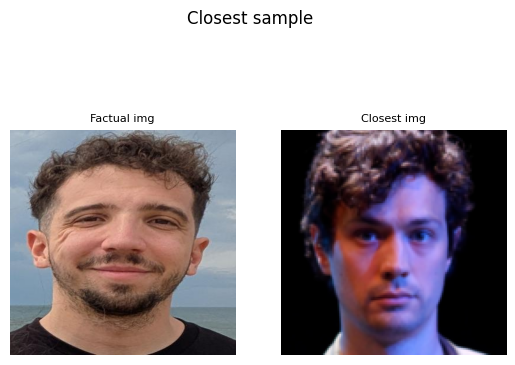

In [17]:
# Plot factual image and closest image

closest_sample_idx = distances_between_image_sets(normalize_0_1(imgs[sample_idx]), distance_metric = 'ssim')

closest_sample = sample_images[closest_sample_idx]
closest_sample = closest_sample
closest_sample = closest_sample.squeeze(0).permute(1, 2, 0).cpu().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img)
ax2.imshow(closest_sample)
ax1.title.set_text('Factual img')
ax1.title.set_fontsize(8)
ax2.title.set_text('Closest img')
ax2.title.set_fontsize(8) 
ax1.axis('off')
ax2.axis('off')
fig.suptitle('Closest sample')